# Predicting Individual IMFs with MLP Networks

In [1]:
from pathlib import Path

import gsod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

gsod.enable_svg_graphing()
gsod.suppress_tf_log()

Init Plugin
Init Graph Optimizer
Init Kernel


Load dataset.

In [2]:
STATION = "722860"
ds = gsod.GsodDataset("runtime/GSOD")
filled = ds.read_continuous(stn=STATION, year="????", fill="ffill")
filled.describe().T

,count,mean,std,min,25%,50%,75%,max
STN,32385.0,722860.000000,0.000000,722860.0,722860.0,722860.0,722860.0,722860.00
WBAN,32385.0,27456.185734,17738.133352,23119.0,23119.0,23119.0,23119.0,99999.00
TEMP,32385.0,62.592605,11.069266,31.1,53.9,61.5,71.3,105.40
COUNT_TEMP,32385.0,23.368813,2.849392,4.0,24.0,24.0,24.0,24.00
DEWP,32385.0,376.818363,1790.020008,-14.4,37.9,46.5,53.0,9999.90
COUNT_DEWP,32385.0,23.055334,4.407043,0.0,24.0,24.0,24.0,24.00
SLP,32385.0,1111.166861,925.086804,994.3,1012.1,1014.4,1017.6,9999.90
COUNT_SLP,32385.0,18.953528,7.226966,0.0,8.0,24.0,24.0,24.00
STP,32385.0,5611.575257,4517.812731,939.4,960.3,9999.9,9999.9,9999.90
COUNT_STP,32385.0,9.315393,10.875566,0.0,0.0,0.0,24.0,24.00


Load CEEMDAN decomposition results.
Run `10-EMD.ipynb` first if you havn't done so.

In [3]:
imfs_array = np.load("runtime/imfs.npy")
imfs = pd.DataFrame(imfs_array.T,
                    columns=[f"IMF_{n+1}" for n in range(len(imfs_array))])
imfs.index = filled.index
dataframe = pd.merge(filled, imfs, how="left",
                     left_index=True, right_index=True)
imfs.describe().T

,count,mean,std,min,25%,50%,75%,max
IMF_1,32385.0,-0.010341,1.448780,-7.619775,-0.938657,-0.025685,0.899248,7.339371
IMF_2,32385.0,-0.000769,0.229555,-1.873865,-0.148163,-0.002532,0.145699,2.381269
IMF_3,32385.0,-0.002342,1.173247,-6.153759,-0.737930,-0.009505,0.718905,5.660010
IMF_4,32385.0,-0.007225,1.720509,-9.036885,-1.152501,-0.018415,1.136218,9.461683
IMF_5,32385.0,-0.008126,1.716780,-7.370834,-1.199286,-0.027894,1.172238,6.879642
IMF_6,32385.0,-0.006295,1.587482,-5.899611,-1.146065,0.001791,1.115562,6.086489
IMF_7,32385.0,-0.003402,1.457385,-4.969838,-1.034858,-0.007800,1.053806,5.542054
IMF_8,32385.0,0.003878,1.177733,-4.540745,-0.800170,-0.010096,0.822102,5.078037
IMF_9,32385.0,-0.631664,6.886718,-13.717210,-6.493557,-1.907737,5.688205,14.087583
IMF_10,32385.0,-0.025981,2.868308,-7.265178,-2.248982,-0.039295,2.231048,6.651529


Specification for the MLP model, training parameters, and helper functions.

In [4]:
WIDTH = 7
MAX_EPOCHS = 100
N_BATCH = 64
# Features other than the IMF
# "DEWP", , "STP", "VISIB", "WDSP", "MXSPD", "GUST", "MAX", "MIN", "PRCP", "SNDP"
OTHER_FEATURES = []


def build_compile_model() -> tf.keras.Model:
    """Specify and compile a model."""
    input_layer = tf.keras.Input(
        # Enable to use stateful model
        # batch_shape=(N_BATCH, WIDTH, len(OTHER_FEATURES) + 1)
        shape=(WIDTH, len(OTHER_FEATURES) + 1)
    )
    mlp = tf.keras.layers.Dense(128, activation="relu")(input_layer)
    mlp = tf.keras.layers.Dense(128, activation="relu")(mlp)
    mlp = tf.keras.layers.Dense(128, activation="relu")(mlp)
    mlp = tf.keras.layers.Dropout(0.2)(mlp)
    mlp = tf.keras.layers.Dense(64, activation="relu")(mlp)
    mlp = tf.keras.layers.Dense(1, activation="relu")(mlp)
    model = tf.keras.Model(inputs=input_layer, outputs=mlp)
    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()]
    )
    return model


def fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        mode="min"
    )
    history = model.fit(
        window.train, epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
        verbose=0, shuffle = False
    )
    return history

In [5]:
val_performance = {}
performance = {}
save_path_template = "runtime/MLP_{imf_name}.h5"
no_reload = False

Train each IMFs with its own models. In my case, CPU is faster.

Training IMF_1Metal device set to: Apple M1

Validating IMF_1
102/102 [==============================] - 0s 3ms/step - loss: 1.9933 - mean_absolute_error: 1.1004
Testing IMF_1
Training IMF_2
Validating IMF_2
102/102 [==============================] - 0s 3ms/step - loss: 0.0499 - mean_absolute_error: 0.1732
Testing IMF_2
Training IMF_3
Validating IMF_3
102/102 [==============================] - 0s 2ms/step - loss: 0.8942 - mean_absolute_error: 0.7437
Testing IMF_3
Training IMF_4
Validating IMF_4
102/102 [==============================] - 0s 2ms/step - loss: 0.9126 - mean_absolute_error: 0.7755
Testing IMF_4
Training IMF_5
Validating IMF_5
102/102 [==============================] - 0s 3ms/step - loss: 0.3663 - mean_absolute_error: 0.4909
Testing IMF_5
Training IMF_6
Validating IMF_6
102/102 [==============================] - 0s 2ms/step - loss: 0.1161 - mean_absolute_error: 0.2771
Testing IMF_6
Training IMF_7
Validating IMF_7
102/102 [==============================] - 0s 2ms/step - loss:

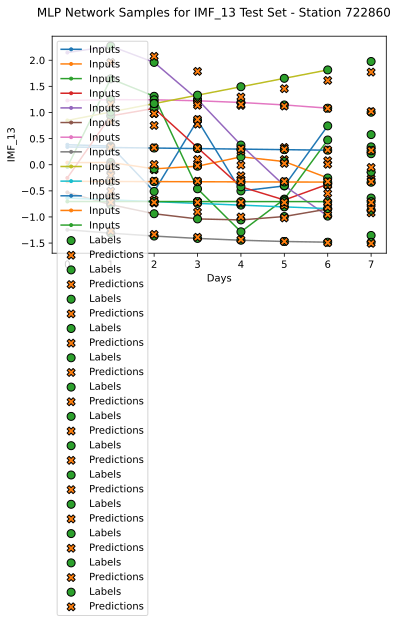

In [6]:
with tf.device("/cpu:0"):
    # Skip the last (trend) IMF
    for imf_name in (f"IMF_{n}" for n in range(1, len(imfs.T))):
        save_path = None
        if save_path_template is not None:
            save_path = Path(save_path_template.format(imf_name=imf_name))
        print(f"Training {imf_name}")
        wide_window = gsod.WindowGenerator(
            df=dataframe[[imf_name] + OTHER_FEATURES],
            input_width=WIDTH, label_width=WIDTH, shift=1,
            batch_size=N_BATCH, label_columns=[imf_name]
        )
        if save_path is not None and save_path.exists() and not no_reload:
            lstm_model = tf.keras.models.load_model(save_path)
        else:
            lstm_model = build_compile_model()
            fit(lstm_model, wide_window)
        print(f"Validating {imf_name}")
        val_performance[f"{imf_name}"] = lstm_model.evaluate(wide_window.val)
        print(f"Testing {imf_name}")
        performance[f"{imf_name}"] = lstm_model.evaluate(wide_window.test,
                                                         verbose=0)
        wide_window.plot(model=lstm_model, max_subplots=1, plot_col=imf_name,
                         dataset="test", network_name="MLP", station_name=STATION)
        if save_path is not None:
            lstm_model.save(save_path)
        tf.keras.backend.clear_session()

Show the metrics of the final result.

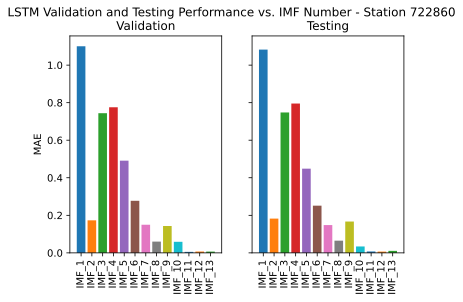

In [7]:
fig, ax = plt.subplots(1, 2, sharey=True)
plt.suptitle(f"LSTM Validation and Testing Performance vs. IMF Number "
             + f"- Station {STATION}")
ax[0].yaxis.label.set_text("MAE")
ax[0].title.set_text("Validation")
ax[0].tick_params("x", labelrotation=90)
for perf in val_performance.keys():
    ax[0].bar(perf, val_performance[perf][1])
ax[1].title.set_text("Testing")
ax[1].tick_params("x", labelrotation=90)
for perf in performance.keys():
    ax[1].bar(perf, performance[perf][1])

Save the metrics for comparison

In [8]:
import json
json.dump({"val": val_performance, "test": performance}, open("runtime/mlp_perf.json", "w"))